In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DIPLOMADO/chineseMNIST.csv')

In [25]:
# Ajustes de etiquetas de los valores
df['label'].replace({100: 11, 1000: 12, 10000: 13, 100000000: 14}, inplace=True)

# Separar características y etiquetas
x = df.iloc[:, :4096]   #Se tienen los datos de imagenes de 64x64 pixeles
y = df['label']

In [26]:
# División de datos: entrenamiento, validación y prueba
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=20) #70% para el entrenamiento
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=20) #15% validacion y 15% prueba

In [27]:
# Normalización (se pasan los valores a un rango de 0 y 1) y reshape
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.to_numpy().reshape(-1, 64, 64, 1) #Se pasan los datos a imagenes de 64x64 pixeles
x_val = x_val.to_numpy().reshape(-1, 64, 64, 1)
x_test = x_test.to_numpy().reshape(-1, 64, 64, 1)


In [28]:
# Para mejor procesamiento en el modelo, se clasifica binariamente usando 15 clases
y_train = to_categorical(y_train, num_classes=15)
y_val = to_categorical(y_val, num_classes=15)
y_test = to_categorical(y_test, num_classes=15)

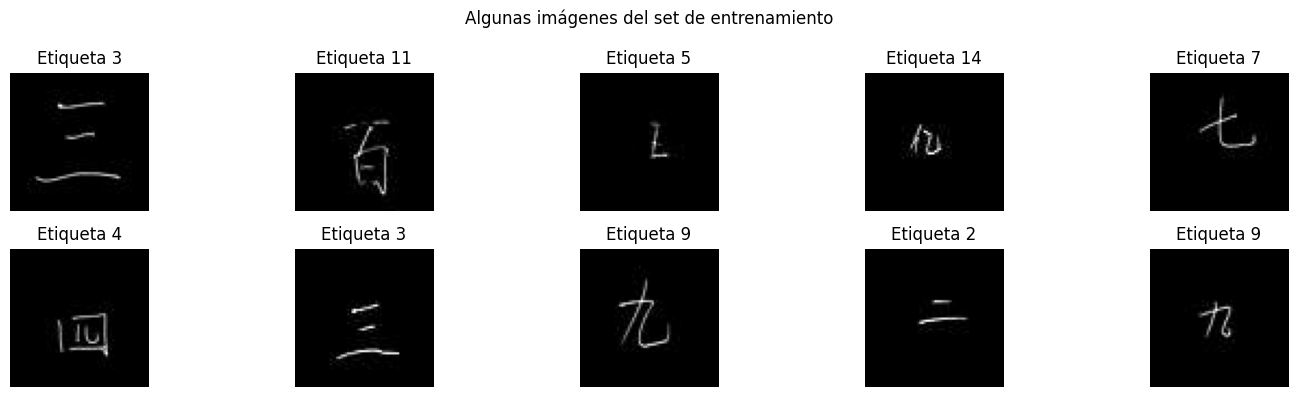

In [37]:
# Visualizamos algunas de las imagenes de la base
def mostrar_imagenes(dataset, labels, title="Imágenes"):
    plt.figure(figsize=(15, 4))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(dataset[i].reshape(64, 64), cmap='gray')
        plt.title(f"Etiqueta {np.argmax(labels[i])}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

mostrar_imagenes(x_train, y_train, "Algunas imágenes del set de entrenamiento")

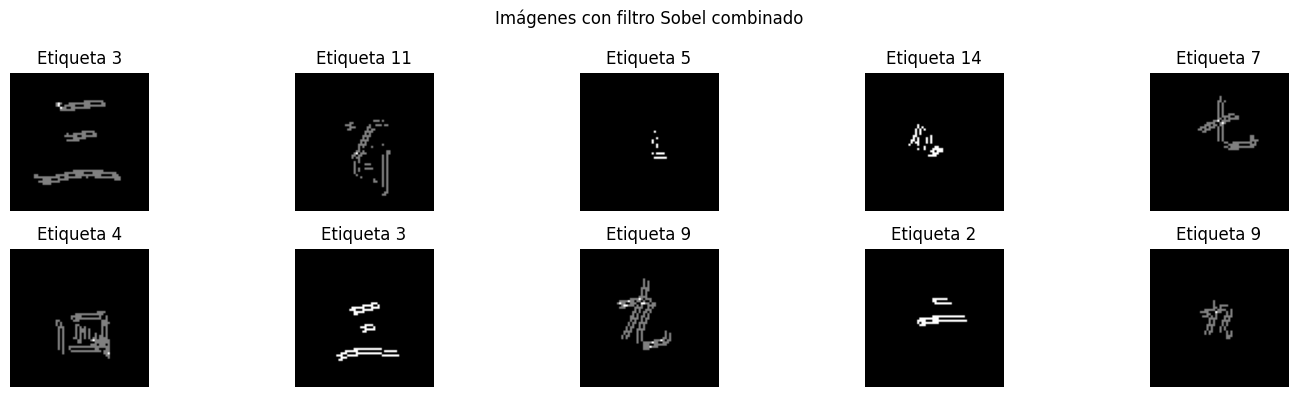

In [39]:
#Se aplica el filtro sobel

def aplicar_filtro_convolucion(imagen):
    imagen_2d = imagen.reshape(64, 64)

    # Definición de kernels Sobel
    sobel_x_kernel = np.array([[-1, 0, 1],
                               [-2, 0, 2],
                               [-1, 0, 1]], dtype=np.float32)

    sobel_y_kernel = np.array([[-1, -2, -1],
                               [ 0,  0,  0],
                               [ 1,  2,  1]], dtype=np.float32)

    # Aplicación de los filtros Sobel manualmente
    sobel_x = cv2.filter2D(imagen_2d, cv2.CV_64F, sobel_x_kernel)
    sobel_y = cv2.filter2D(imagen_2d, cv2.CV_64F, sobel_y_kernel)

    # Combinación de ambos (media ponderada)
    sobel_combined = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

    # Normalizamos para que esté en el rango [0, 255]
    sobel_combined = cv2.convertScaleAbs(sobel_combined)

    return sobel_combined.reshape(64, 64, 1)

# Aplicar a los conjuntos
x_train_filt = np.array([aplicar_filtro_convolucion(img) for img in x_train])
x_val_filt = np.array([aplicar_filtro_convolucion(img) for img in x_val])
x_test_filt = np.array([aplicar_filtro_convolucion(img) for img in x_test])

# Mostrar imágenes filtradas
mostrar_imagenes(x_train_filt, y_train, "Imágenes con filtro Sobel combinado")


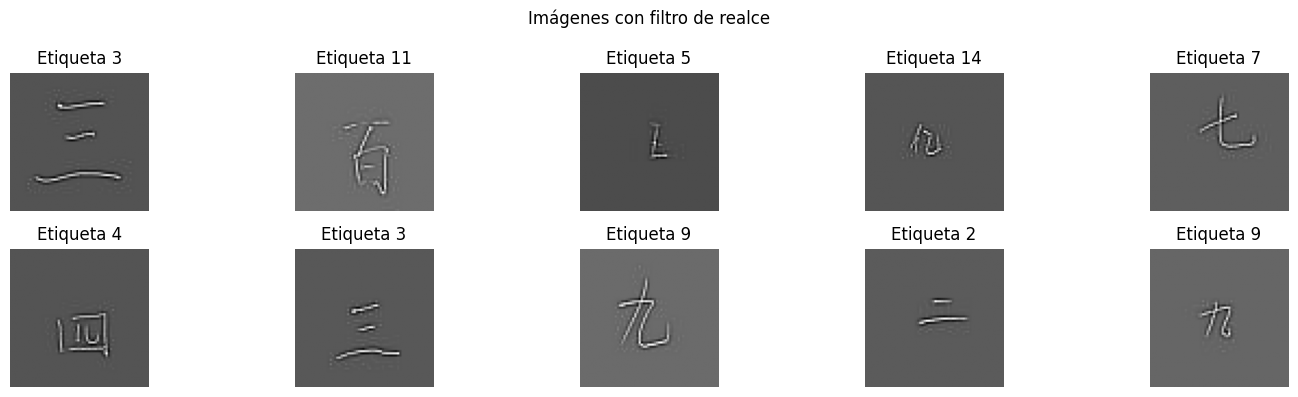

In [50]:
# Se aplica un filtro de realce de bordes y se muestran las imagenes

def aplicar_filtro_convolucion(imagen):
    imagen_2d = imagen.reshape(64, 64)
    kernel = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])  # Kernel de realce (detector de bordes)
    imagen_filtrada = cv2.filter2D(imagen_2d, -1, kernel)
    return imagen_filtrada.reshape(64, 64, 1)

x_train_filt = np.array([aplicar_filtro_convolucion(img) for img in x_train])
x_val_filt = np.array([aplicar_filtro_convolucion(img) for img in x_val])
x_test_filt = np.array([aplicar_filtro_convolucion(img) for img in x_test])


mostrar_imagenes(x_train_filt, y_train, "Imágenes con filtro de realce")

In [42]:
# Construcción del modelo CNN
def construir_modelo():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(15, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [43]:
# Entrenamiento del modelo con imágenes originales
modelo_original = construir_modelo()
hist_original = modelo_original.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 54s 157ms/step - accuracy: 0.4900 - loss: 1.6078 - val_accuracy: 0.8907 - val_loss: 0.3701
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - accuracy: 0.9041 - loss: 0.3069 - val_accuracy: 0.9338 - val_loss: 0.2061
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.9547 - loss: 0.1451 - val_accuracy: 0.9511 - val_loss: 0.1578
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 54s 163ms/step - accuracy: 0.9706 - loss: 0.0937 - val_accuracy: 0.9529 - val_loss: 0.1633
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 161ms/step - accuracy: 0.9838 - loss: 0.0578 - val_accuracy: 0.9502 - val_loss: 0.1814
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 57s 174ms/step - accuracy: 0.9844 - loss: 0.0495 - val_accuracy: 0.9689 - val_loss: 0.1297
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 79s 166ms/step - accuracy: 0.9958 - loss: 0.0186 - val_accuracy: 0.9653 - val_loss: 0.1362
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.9870 - loss: 0

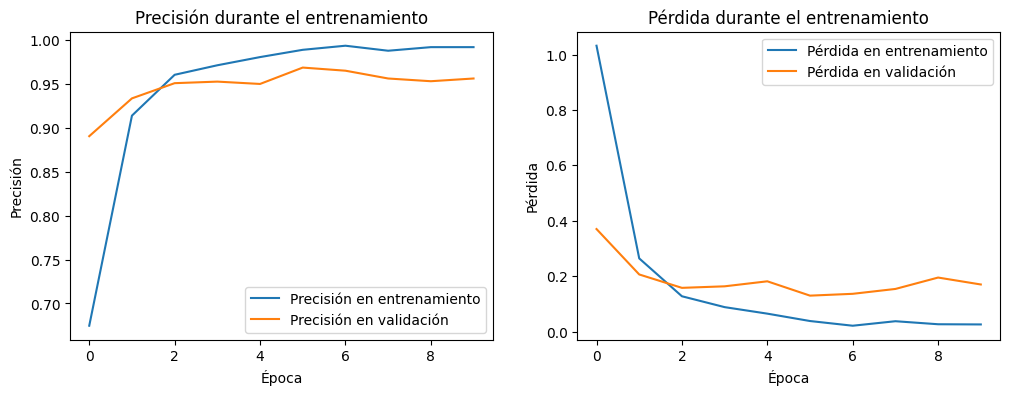

In [44]:
# Gráficos de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_original.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(hist_original.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_original.history['loss'], label='Pérdida en entrenamiento')
plt.plot(hist_original.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [45]:
# Predicciones y métricas
y_pred = modelo_original.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


In [46]:
# Clasificación
print("\nReporte de clasificación:\n")
print(classification_report(y_true_labels, y_pred_labels))



Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.97      0.98      0.98       160
           2       0.83      0.91      0.87       139
           3       0.94      0.82      0.88       144
           4       0.98      1.00      0.99       161
           5       0.96      0.97      0.97       148
           6       0.97      0.99      0.98       150
           7       0.94      0.94      0.94       138
           8       0.99      0.99      0.99       137
           9       0.95      0.92      0.94       158
          10       0.97      0.93      0.95       148
          11       0.96      0.93      0.95       163
          12       0.90      0.94      0.92       159
          13       0.98      0.96      0.97       143
          14       0.95      0.98      0.96       165

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      225

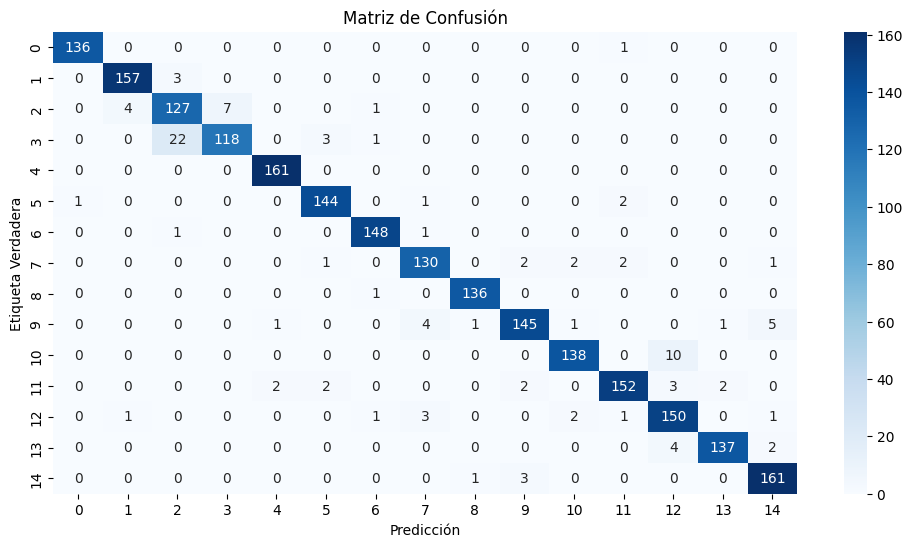

In [47]:
# Matriz de confusión
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.show()

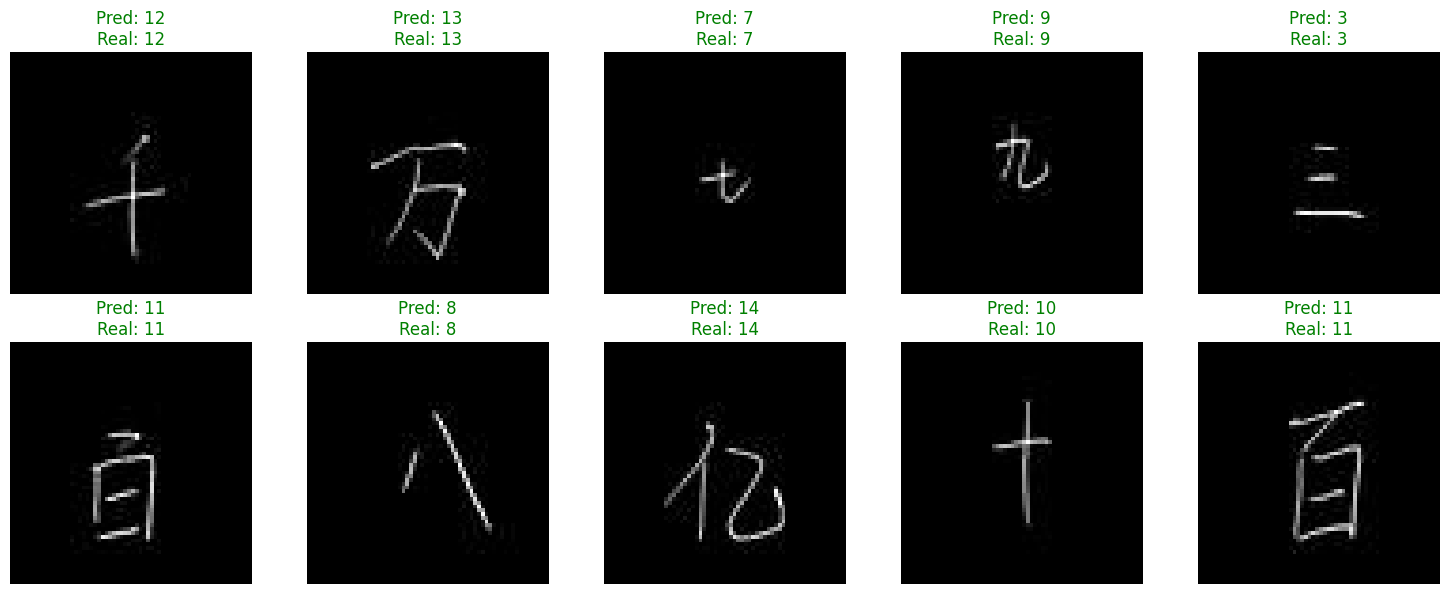

In [48]:
# Visualizar algunas predicciones
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(64, 64), cmap='gray')
    color = 'green' if y_pred_labels[i] == y_true_labels[i] else 'red'
    plt.title(f"Pred: {y_pred_labels[i]}\nReal: {y_true_labels[i]}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [51]:
# Entrenamiento del modelo con imágenes con filtro
modelo_filtrado = construir_modelo()
hist_filtrado = modelo_filtrado.fit(x_train_filt, y_train, validation_data=(x_val_filt, y_val), epochs=10, batch_size=32)

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 55s 162ms/step - accuracy: 0.5917 - loss: 1.3015 - val_accuracy: 0.9147 - val_loss: 0.2600
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 150ms/step - accuracy: 0.9401 - loss: 0.1821 - val_accuracy: 0.9453 - val_loss: 0.1616
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - accuracy: 0.9722 - loss: 0.0871 - val_accuracy: 0.9631 - val_loss: 0.1246
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.9841 - loss: 0.0551 - val_accuracy: 0.9627 - val_loss: 0.1254
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.9878 - loss: 0.0367 - val_accuracy: 0.9484 - val_loss: 0.1714
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9872 - loss: 0.0440 - val_accuracy: 0.9684 - val_loss: 0.1186
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 84s 161ms/step - accuracy: 0.9949 - loss: 0.0188 - val_accuracy: 0.9702 - val_loss: 0.1268
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - accuracy: 0.9989 - loss: 0

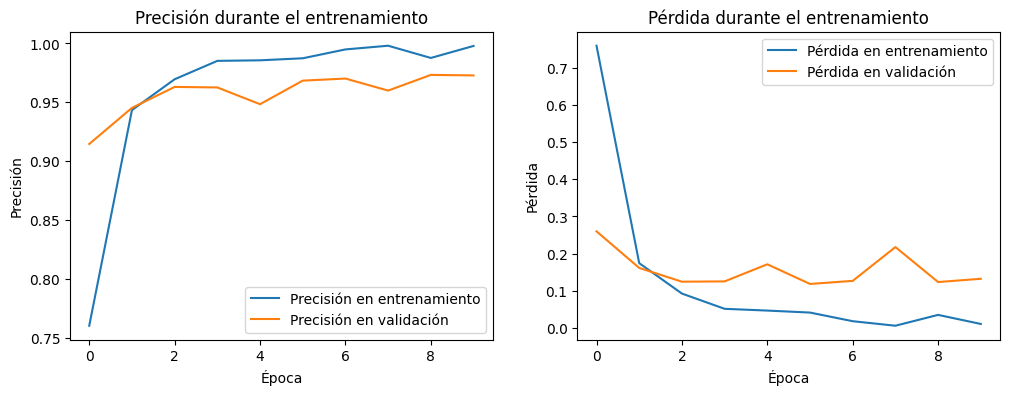

In [52]:
# Gráficos de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_filtrado.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(hist_filtrado.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_filtrado.history['loss'], label='Pérdida en entrenamiento')
plt.plot(hist_filtrado.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [56]:
# Predicciones y métricas
y_pred = modelo_original.predict(x_test_filt)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


In [57]:
# Clasificación
print("\nReporte de clasificación:\n")
print(classification_report(y_true_labels, y_pred_labels))


Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       137
           1       0.97      0.47      0.63       160
           2       0.48      0.58      0.53       139
           3       0.70      0.95      0.81       144
           4       0.98      0.98      0.98       161
           5       0.94      0.97      0.95       148
           6       0.94      0.99      0.96       150
           7       0.94      0.88      0.91       138
           8       1.00      0.99      0.99       137
           9       0.99      0.78      0.88       158
          10       1.00      0.61      0.76       148
          11       0.92      0.90      0.91       163
          12       0.74      0.95      0.83       159
          13       0.94      0.95      0.94       143
          14       0.81      0.99      0.89       165

    accuracy                           0.87      2250
   macro avg       0.89      0.87      0.86      225

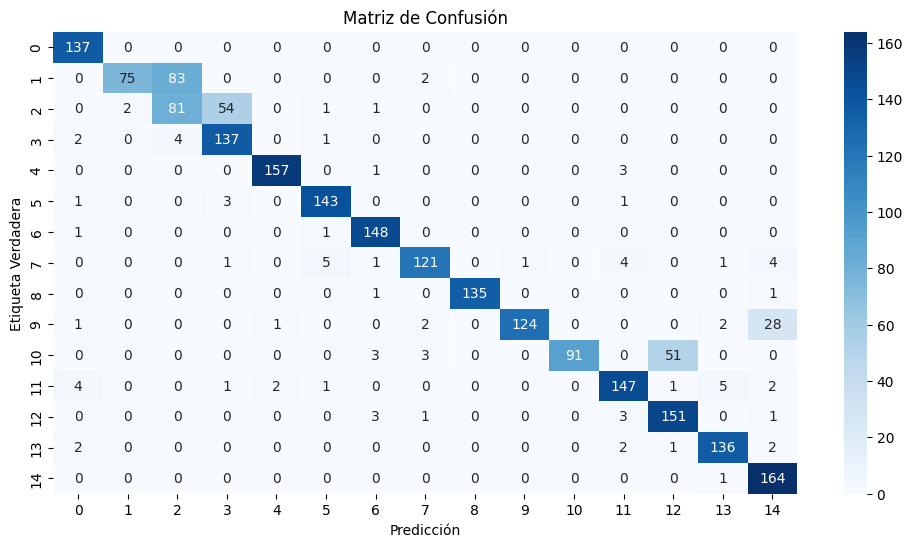

In [58]:
# Matriz de confusión
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_true_labels2, y_pred_labels2), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.show()

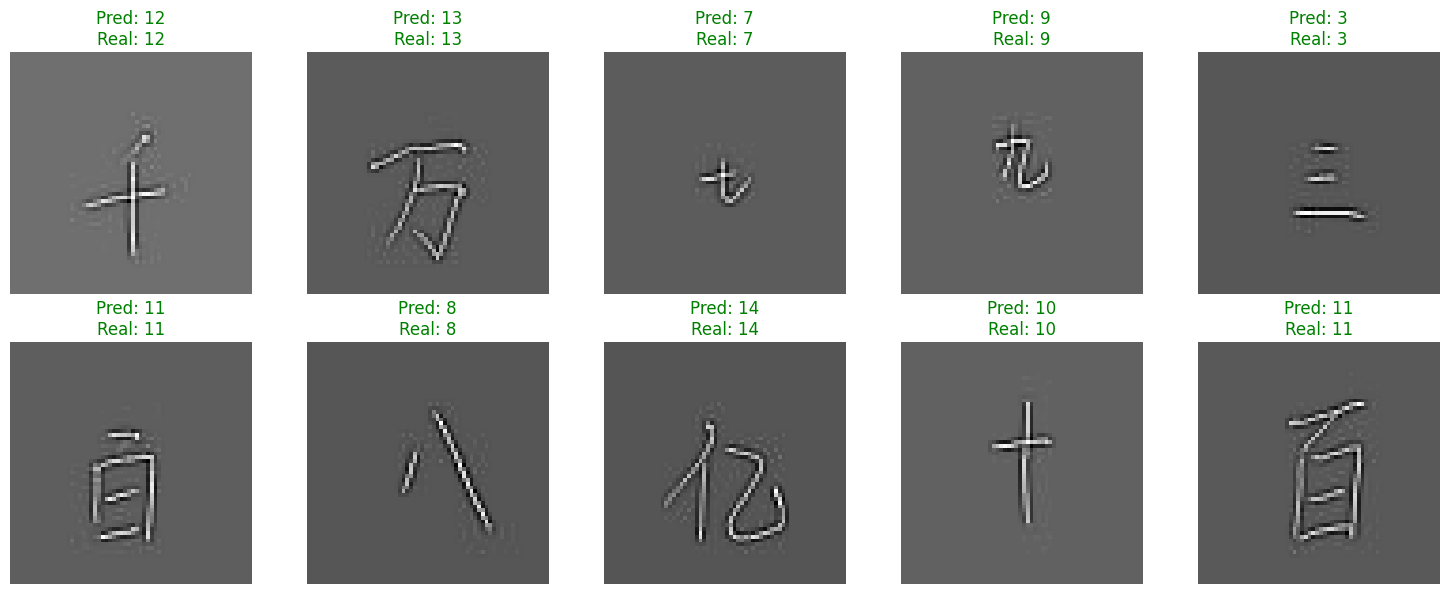

In [59]:
# Visualizar algunas predicciones
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test_filt[i].reshape(64, 64), cmap='gray')
    color = 'green' if y_pred_labels2[i] == y_true_labels2[i] else 'red'
    plt.title(f"Pred: {y_pred_labels2[i]}\nReal: {y_true_labels2[i]}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


A pesar de que se esperaba un mejor rendimiento a la red usando las imagenes con filtro, esto no fue así. Sólo en la parte del entrenamiento, incluso desde las epocas iniciales se vieron mejores resultados que sin filtro. No obstante, con las imagenes de prueba fue lo contrario y los mejores resultados fueron de las imagenes sin filtro (con accuracy de 0.95) en comparación con las cpn filtro (con accuracy de 0.89)